# CMIP6 object store and `intake-esm`

Using a datastore and the `intake-esm` package can greatly simplify searching for available CMIP6 data (e.g. from different models, experiments, variables). 

## JASMIN CMIP6 object store

First we try using the [CMIP6 object store for JASMIN](https://github.com/cedadev/cmip6-object-store). I don't think this object store very complete at the moment, but it does have the advantage of pointing directly to the CMIP6 data on JASMIN which is close to the computation.

In [1]:
import xarray as xr
import intake
import intake_esm
import fsspec
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%config InlineBackend.figure_format = 'retina'
import warnings

warnings.filterwarnings("ignore")

In [2]:
col_url = "https://raw.githubusercontent.com/cedadev/" \
          "cmip6-object-store/master/catalogs/ceda-zarr-cmip6.json"
col = intake.open_esm_datastore(col_url)
f'There are {len(col.df)} datasets'

'There are 62943 datasets'

In [3]:
cat = col.search(source_id="UKESM1-0-LL",
    experiment_id=["historical", "ssp585-bgc"], 
    member_id=["r4i1p1f2", "r12i1p1f2"],
    table_id="Amon",
    variable_id="tas")


# Extract the single record subsets for historical and future experiments
hist_cat = cat.search(experiment_id='historical')
ssp_cat = cat.search(experiment_id='ssp585-bgc')

In [4]:
def cat_to_ds(cat):
    zarr_path = cat.df['zarr_path'][0] # read the first ensemble member
    fsmap = fsspec.get_mapper(zarr_path)
    return xr.open_zarr(fsmap, consolidated=True, use_cftime=True)

In [5]:
hist_tas = cat_to_ds(hist_cat)['tas']
ssp_tas = cat_to_ds(ssp_cat)['tas']
print(hist_tas)

<xarray.DataArray 'tas' (time: 1980, lat: 144, lon: 192)>
dask.array<open_dataset-0f0c5ecce77e854a3d66827fbf6e6fe9tas, shape=(1980, 144, 192), dtype=float32, chunksize=(1980, 144, 192), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * time     (time) object 1850-01-16 00:00:00 ... 2014-12-16 00:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    history:        2019-12-06T11:04:18Z altered by CMOR: Treated scalar dime...
    long_name:      Near-Surface Air Temperature
    original_name:  mo: (stash: m01s03i236, lbproc: 128)
    standard_name:  air_temperature
    units:          K


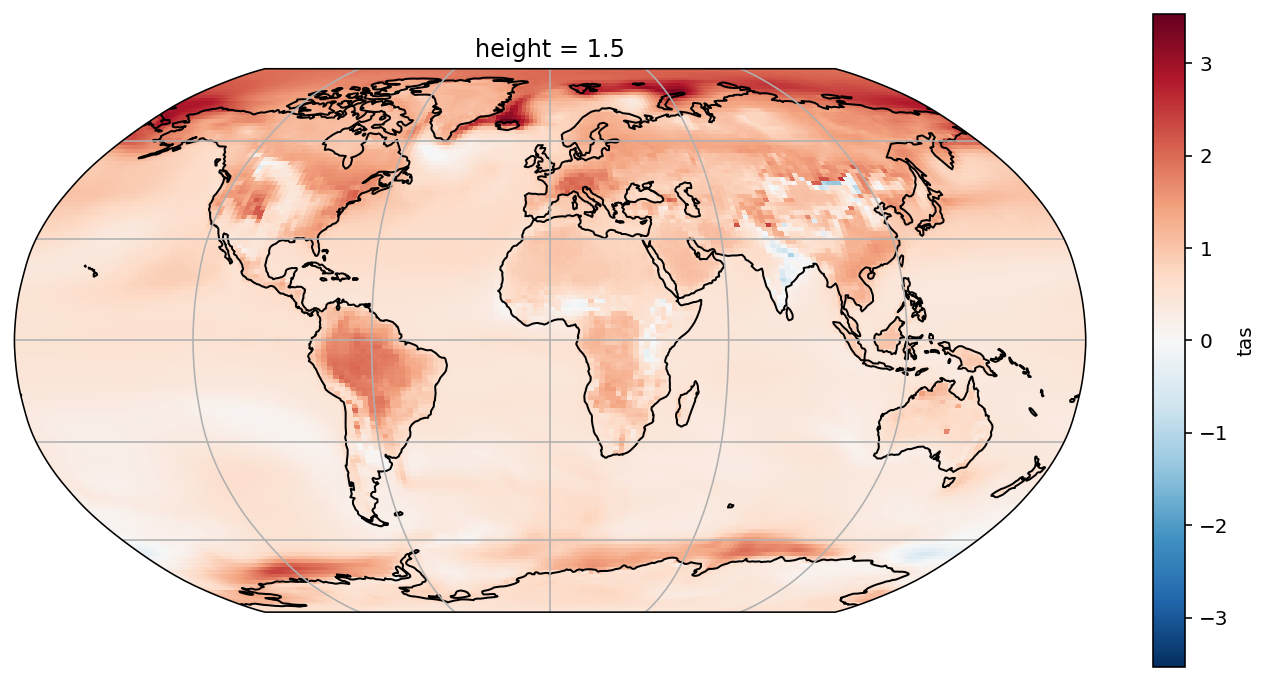

In [6]:
# Calculate time means
diff = ssp_tas.mean(axis=0) - hist_tas.mean(axis=0)

# Plot a map of the time-series means
plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
diff.plot(ax=ax, transform=ccrs.PlateCarree())

# Pangeo CMIP6 store on Google Cloud

Next we'll try reading from the Pangeo store of CMIP6 data, which is hosted on Google Cloud. This is physically further from the computation so likely to be slower.

In [7]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
col

,unique
activity_id,17
institution_id,36
source_id,86
experiment_id,168
member_id,650
table_id,37
variable_id,709
grid_label,10
zstore,497672
dcpp_init_year,60


In [8]:
cat = col.search(
    experiment_id=["historical", "ssp585"],
    table_id="Oyr",
    variable_id="o2",
    grid_label="gn",
)

cat

,unique
activity_id,2
institution_id,13
source_id,15
experiment_id,2
member_id,47
table_id,1
variable_id,1
grid_label,1
zstore,180
dcpp_init_year,0


In [9]:
dset_dict = cat.to_dataset_dict(
    zarr_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True}
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [10]:
ds = dset_dict["CMIP.CCCma.CanESM5.historical.Oyr.gn"]
print(ds)

<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 291, lev: 45, member_id: 35, time: 165, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 284 285 286 287 288 289 290
    latitude            (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * lev                 (lev) float64 3.047 9.454 16.36 ... 5.375e+03 5.625e+03
    lev_bnds            (lev, bnds) float64 dask.array<chunksize=(45, 2), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * time                (time) object 1850-07-02 12:00:00 ... 2014-07-02 12:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(165, 2), meta=np.ndarray>
  * member_id           (member_id) <U9 'r10i1p1f1' 'r4i1p1f1' ... 'r7i1p1f1'
Dimensions without coordinates: bnds, vertices
Data variables:
    o2                  (member_id, time, lev, j,

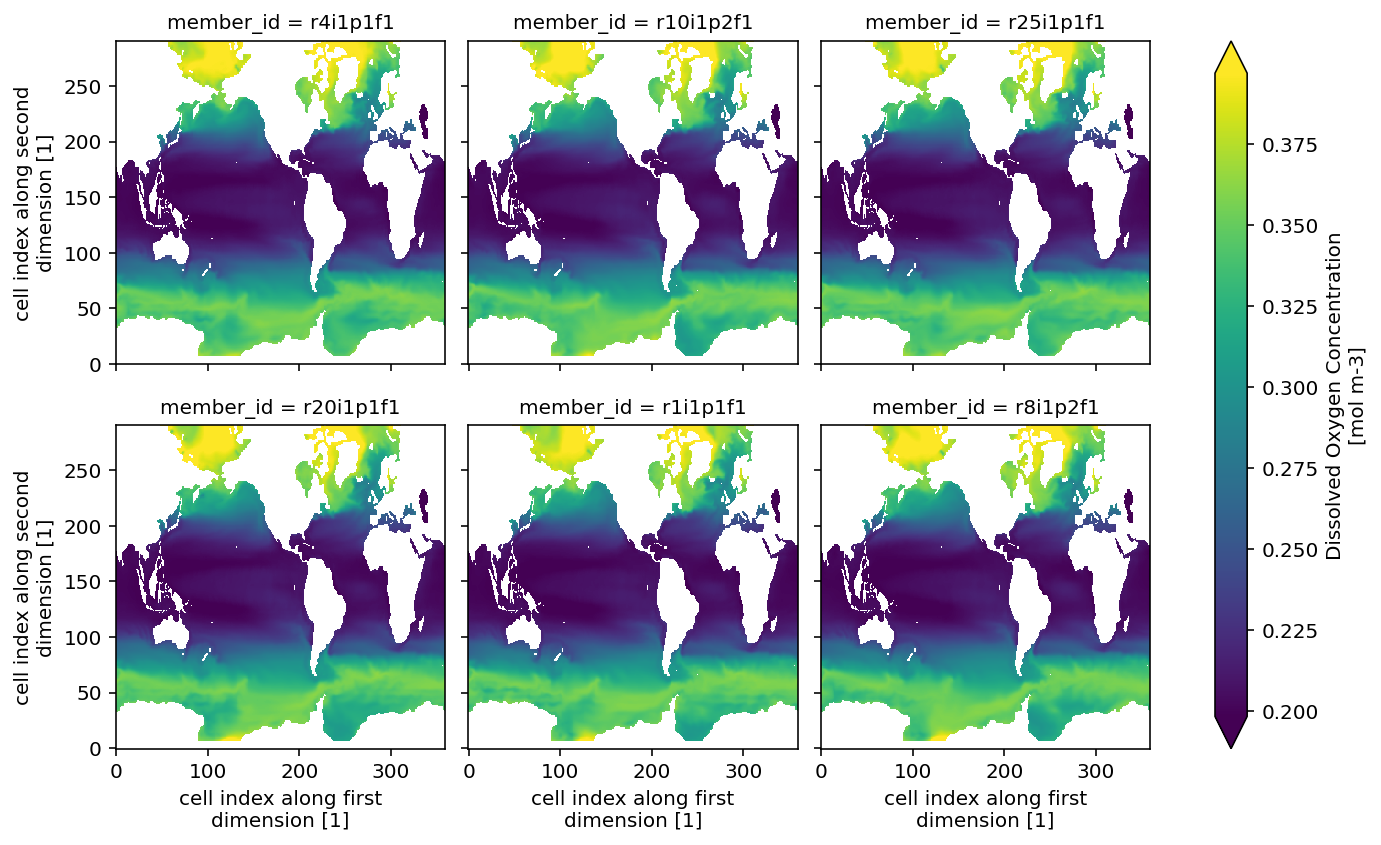

In [11]:
ds.o2.isel(time=0, lev=0, member_id=range(1, 24, 4)).plot(col="member_id", col_wrap=3, robust=True)
